In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!tar xvf ./drive/'My Drive'/'cub'/CUB_200_2011.tgz 

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0002_112905.j

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import timeit
from mlmodel import *
import pickle
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
import utils
from torchvision import transforms
import torchvision.models as models
from torch import nn

In [6]:
model_pre = models.resnet101(pretrained=True)
print(list(model_pre.children())[0])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [7]:
class res101_featureExtract(nn.Module):
    def __init__(self, model):
        super(res101_featureExtract, self).__init__() 
        self.features = nn.Sequential(*list(model.children())[:-1])       
    def forward(self, x):
        x = self.features(x)       
        return x
feature_model = res101_featureExtract(model_pre)
#print(list(feature_model.children())[0])

In [8]:
# !ls
# !ls ./CUB_200_2011/images/001.Black_footed_Albatross/

In [9]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
path = './CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpg'
image = cv2.imread(path)
image = Image.open(path)

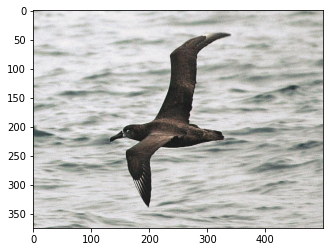

In [10]:
plt.imshow(image)
plt.show()

In [11]:
trans = transforms.ToTensor()
ii = torch.unsqueeze(trans(image),0)
print(ii.shape)
featrue = feature_model(ii)
print(featrue.size())

torch.Size([1, 3, 375, 500])
torch.Size([1, 2048, 1, 1])


In [12]:
path_indx_name = './CUB_200_2011/images.txt'
path_indx_class = './CUB_200_2011/image_class_labels.txt'

data_indx_name = pd.read_csv(path_indx_name, sep=" ", header=None)
print(data_indx_name)
data_indx_class = pd.read_csv(path_indx_class, sep=" ", header=None)
print(data_indx_class)

data = pd.concat([data_indx_name, data_indx_class], axis=1)
#df.rename(columns={'0': 'a'})
print(data)

           0                                                  1
0          1  001.Black_footed_Albatross/Black_Footed_Albatr...
1          2  001.Black_footed_Albatross/Black_Footed_Albatr...
2          3  001.Black_footed_Albatross/Black_Footed_Albatr...
3          4  001.Black_footed_Albatross/Black_Footed_Albatr...
4          5  001.Black_footed_Albatross/Black_Footed_Albatr...
...      ...                                                ...
11783  11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784  11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785  11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786  11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787  11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
           0    1
0          1    1
1          2    1
2          3    1
3          4    1
4          5    1
...      ...  ...
11783  11784  200
11784  11785  200
11785  11786  200
11786  11787  200
11787  1

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#model_ft = model_ft.to(device)

cuda:0


In [14]:
#inception_v3
# model_pre = models.inception_v3(pretrained=True)
# print(list(model_pre.children())[0])

In [20]:
def genFeature(data, path_prefix, feature_model, device):
    feature_lst = []
    label_lst = []
    dim = 2048
    trans = transforms.ToTensor()
    i = 0
    less_channel = []
    feature_model = feature_model.to(device)
    for cur_data in data.iterrows():
        i+=1
        # if i >10:
        #     break
        # print('cur_data ', cur_data)
        #print(cur_data[1], cur_data[1].to_numpy())
        cur_data_np = cur_data[1].to_numpy()
        img_path = path_prefix + cur_data_np[1]
        print(img_path)
        try:
          image = Image.open(img_path)
        except FileNotFoundError as error:
          print('error occur ', error)
          continue
        

        ii = torch.unsqueeze(trans(image), 0)
        ii = ii.to(device)
        try:
          featrue = torch.squeeze(feature_model(ii))
        except RuntimeError as error:
          print('error occur ', error)
          less_channel.append(img_path)
          continue
        #print(featrue.size())
        # plt.imshow(image)
        # plt.show()

        feature_lst.append(np.expand_dims(utils.toNumpy(featrue.cpu()), 0))
        # temp = np.expand_dims(utils.toNumpy(featrue), 0)
        # print(temp.shape)
        label_lst.append(cur_data_np[-1])
    
    label_lst = np.expand_dims(np.array(label_lst), axis=0)
    print('label_lst ', label_lst.shape)
    feature_lst = np.concatenate(feature_lst, axis=0)
    print(feature_lst.shape)
    data_label_feature_np = np.hstack((label_lst.T, feature_lst))
    data_label_feature =  pd.DataFrame(data_label_feature_np,
                   columns=['label'] +[i for i in range(dim)])
    print(data_label_feature)
    print('tot count ', i)
    return data_label_feature, less_channel
    
        

path_prefix = './CUB_200_2011/images/'
data_label_feature, image_path = genFeature(data, path_prefix, feature_model, device)


Streaming output truncated to the last 5000 lines.
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0075_797251.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0034_797252.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0080_797253.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0064_110664.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0023_797258.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0085_797260.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0090_110669.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0010_797262.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0003_110672.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0093_110677.jpg
./CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0081_110682.jpg
./CUB_200_2011/images/117

In [21]:
print(data_label_feature)
print(image_path)

       label         0         1  ...      2045      2046      2047
0        1.0  0.554742  0.449377  ...  0.439953  0.524471  0.418162
1        1.0  0.518317  0.397836  ...  0.405931  0.498380  0.382074
2        1.0  0.509601  0.438840  ...  0.452037  0.484544  0.389252
3        1.0  0.527033  0.440028  ...  0.436954  0.560362  0.393463
4        1.0  0.552168  0.386958  ...  0.442812  0.472144  0.385911
...      ...       ...       ...  ...       ...       ...       ...
11775  200.0  0.530580  0.413276  ...  0.430384  0.519709  0.408091
11776  200.0  0.535687  0.457732  ...  0.452918  0.525745  0.382445
11777  200.0  0.514037  0.482673  ...  0.436029  0.505107  0.402101
11778  200.0  0.538375  0.463504  ...  0.397064  0.519759  0.365018
11779  200.0  0.560232  0.476490  ...  0.466036  0.540046  0.443416

[11780 rows x 2049 columns]
['./CUB_200_2011/images/009.Brewer_Blackbird/Brewer_Blackbird_0028_2682.jpg', './CUB_200_2011/images/025.Pelagic_Cormorant/Pelagic_Cormorant_0022_23802.jpg

In [22]:
data_label_feature.to_csv(r'./pandas.txt', header=None, index=None, sep=' ', mode='w')